In [1]:
# The cell below defines the fly-lsh model, lsh model, and the evaluation method.

In [2]:
import random

import numpy as np
import matplotlib.pyplot as plt
from mnist import MNIST
from sklearn.neighbors import NearestNeighbors
from sklearn.random_projection import GaussianRandomProjection


def true_nearest_neighbors(inputs, k=200):
    nbs = NearestNeighbors(k).fit(inputs)
    return nbs.kneighbors(return_distance=False)


def average_precision(prediction, truth):
    score, total = 0, len(prediction)
    for i in range(1, total + 1):
        score += len(set(prediction[:i]) & (set(truth[:i]))) / i

    return score / total


def random_query(mappings, true_nn, num_samples=1000):
    k = true_nn.shape[1]
    nbs = [NearestNeighbors(k + 1).fit(mapping) for mapping in mappings]
    indices = random.sample(range(true_nn.shape[0]), num_samples)
    aps = np.zeros(len(mappings))
    for index in indices:
        predicts = [nbs[i].kneighbors(mappings[i][index].reshape(1, -1), return_distance=False)[:, 1:k+1] 
                    for i in range(len(mappings))]
        aps += [average_precision(true_nn[index], np.squeeze(predict)) for predict in predicts]
    
    return aps / num_samples


def lsh(inputs, hash_len):
    projection = GaussianRandomProjection(hash_len)
    mapping = projection.fit_transform(inputs)

    return mapping


def fly_lsh(inputs, hash_len, ratio=0.1):
    m = int(2 * hash_len / ratio)
#     m = hash_len
    projection = np.random.random((inputs.shape[1], m)) < ratio
    mapping = np.dot(inputs, projection)

    gate = np.argpartition(mapping, -hash_len, axis=1)[:, -hash_len][:, None]
    mapping[mapping < gate] = 0
    

    return mapping

In [3]:
# The cell below defines some utils.

In [4]:
def load_sift(filename):
    data = np.fromfile(filename, dtype=np.float32)
    dim = data.view(np.int32)[0]
    data = data.reshape(-1, 1 + dim)
    return data[:, 1:]


def load_glove(filename):
    with open(filename) as f:
        lines = f.readlines()
        num = 0
        data = []
        for line in lines:
            line = np.array(line.split(' ')[1:], dtype=np.float32)
            data.append(line)
            num += 1
            if num >= 10000:
                break
    return np.array(data)


def preprocess(dataset):
    if dataset == 'MNIST':
        data, _ = MNIST().load_training()
        data = np.array(random.sample(data, 10000))
    elif dataset == 'SIFT':
        data = load_sift('siftsmall_base.fvecs')
    elif dataset == 'GLOVE':
        data = load_glove('glove.6B.300d.txt')
    else:
        print('Error dataset!')
        return
        
    data = data - np.mean(data, axis=1)[:, None]
    true_nns = true_nearest_neighbors(data)
    
    return data, true_nns


def show_image(scores, title, legend_1, legend_2):
    plt.figure()
    plt.grid()
    plt.title(title)
    plt.ylabel('Mean Average Precision')
    plt.xlabel('Hash Length (k)')
    plt.xlim(0, 25)
    plt.ylim(0, 1)
    
    x = scores.keys()
    y_1 = [np.mean(scores[i]['fly_lsh']) for i in x]
    y_2 = [np.mean(scores[i]['lsh']) for i in x]
    err_1 = [np.std(scores[i]['fly_lsh']) for i in x]
    err_2 = [np.std(scores[i]['lsh']) for i in x]
    
    plt.errorbar(x, y_1, yerr=err_1)
    plt.errorbar(x, y_2, yerr=err_2)

    plt.legend([legend_1, legend_2], loc='upper left')
    plt.show()

In [5]:
# The cell below defines the computation process on a dataset.

In [6]:
def compute_scores(dataset):
    data, true_nns = preprocess(dataset)
    scores = {}
    print('Computing score...')
    for hash_length in hash_lengths:
        scores[hash_length] = {}
        scores[hash_length]['fly_lsh'] = []
        scores[hash_length]['lsh'] = []
        for i in range(trials):
            fly_hash = fly_lsh(data, hash_length)
            lsh_hash = lsh(data, hash_length)

            fly_score, lsh_score = random_query((fly_hash, lsh_hash), true_nns)

            scores[hash_length]['fly_lsh'].append(fly_score)        
            scores[hash_length]['lsh'].append(lsh_score)

        print('dataset: %s, hash_length: %s completed.' % (dataset, hash_length))
            
    return scores

In [7]:
# Compute scores on MNIST, SIFT, and GLOVE datasets.

In [8]:
# set parameters
trials = 10
hash_lengths = [2, 4, 8, 12, 16, 20, 24]

scores_mnist = compute_scores('MNIST')
scores_sift = compute_scores('SIFT')
scores_glove = compute_scores('GLOVE')

Computing score...
dataset: MNIST, hash_length: 2 completed.
dataset: MNIST, hash_length: 4 completed.
dataset: MNIST, hash_length: 8 completed.
dataset: MNIST, hash_length: 12 completed.
dataset: MNIST, hash_length: 16 completed.
dataset: MNIST, hash_length: 20 completed.
dataset: MNIST, hash_length: 24 completed.
Computing score...
dataset: SIFT, hash_length: 2 completed.
dataset: SIFT, hash_length: 4 completed.
dataset: SIFT, hash_length: 8 completed.
dataset: SIFT, hash_length: 12 completed.
dataset: SIFT, hash_length: 16 completed.
dataset: SIFT, hash_length: 20 completed.
dataset: SIFT, hash_length: 24 completed.
Computing score...
dataset: GLOVE, hash_length: 2 completed.
dataset: GLOVE, hash_length: 4 completed.
dataset: GLOVE, hash_length: 8 completed.
dataset: GLOVE, hash_length: 12 completed.
dataset: GLOVE, hash_length: 16 completed.
dataset: GLOVE, hash_length: 20 completed.
dataset: GLOVE, hash_length: 24 completed.


In [9]:
# Show the results.

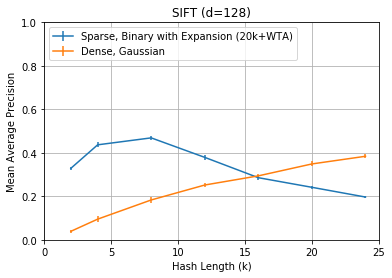

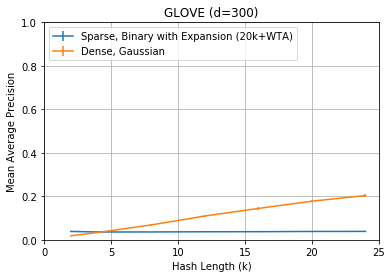

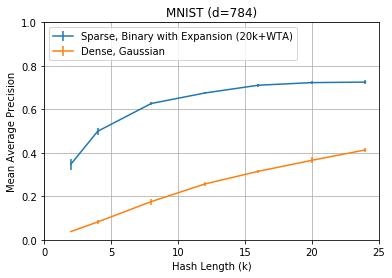

In [10]:
show_image(scores_sift, "SIFT (d=128)", 'Sparse, Binary with Expansion (20k+WTA)', 'Dense, Gaussian')
show_image(scores_glove, "GLOVE (d=300)", 'Sparse, Binary with Expansion (20k+WTA)', 'Dense, Gaussian')
show_image(scores_mnist, "MNIST (d=784)", 'Sparse, Binary with Expansion (20k+WTA)', 'Dense, Gaussian')

In [11]:
# Re-define the fly-lsh model with no expansion (m = k) and no WTA.

In [12]:
def fly_lsh(inputs, hash_len, ratio=0.1):
#     m = int(2 * hash_len / ratio)
    m = hash_len
    projection = np.random.random((inputs.shape[1], m)) < ratio
    mapping = np.dot(inputs, projection)
    
    return mapping

In [13]:
# Re-compute scores on MNIST, SIFT, and GLOVE datasets using new fly-lsh model.

In [14]:
scores_mnist_no_expansion = compute_scores('MNIST')
scores_sift_no_expansion = compute_scores('SIFT')
scores_glove_no_expansion = compute_scores('GLOVE')

Computing score...
dataset: MNIST, hash_length: 2 completed.
dataset: MNIST, hash_length: 4 completed.
dataset: MNIST, hash_length: 8 completed.
dataset: MNIST, hash_length: 12 completed.
dataset: MNIST, hash_length: 16 completed.
dataset: MNIST, hash_length: 20 completed.
dataset: MNIST, hash_length: 24 completed.
Computing score...
dataset: SIFT, hash_length: 2 completed.
dataset: SIFT, hash_length: 4 completed.
dataset: SIFT, hash_length: 8 completed.
dataset: SIFT, hash_length: 12 completed.
dataset: SIFT, hash_length: 16 completed.
dataset: SIFT, hash_length: 20 completed.
dataset: SIFT, hash_length: 24 completed.
Computing score...
dataset: GLOVE, hash_length: 2 completed.
dataset: GLOVE, hash_length: 4 completed.
dataset: GLOVE, hash_length: 8 completed.
dataset: GLOVE, hash_length: 12 completed.
dataset: GLOVE, hash_length: 16 completed.
dataset: GLOVE, hash_length: 20 completed.
dataset: GLOVE, hash_length: 24 completed.


In [15]:
# Show the results.

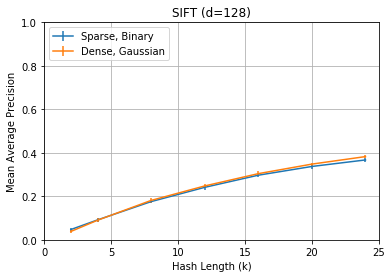

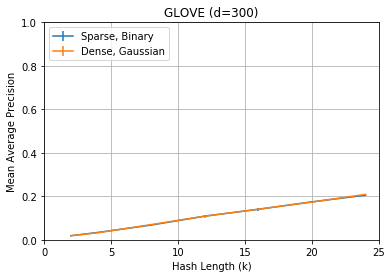

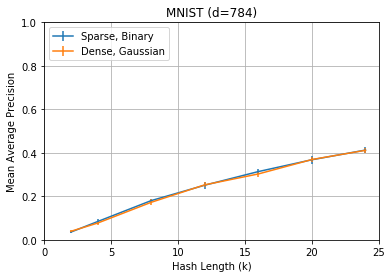

In [16]:
show_image(scores_sift_no_expansion, "SIFT (d=128)", 'Sparse, Binary', 'Dense, Gaussian')
show_image(scores_glove_no_expansion, "GLOVE (d=300)", 'Sparse, Binary', 'Dense, Gaussian')
show_image(scores_mnist_no_expansion, "MNIST (d=784)", 'Sparse, Binary', 'Dense, Gaussian')